# Yolo for lung opacity detection
  

### Brief

*We attempt to predcit lung opacities in X-ray images using the YOLO netowork, on a dataset provided by the RSNA. The link to the dataset can be found [here](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data). A description of the dataset, and details of the Exploratory data analysis can be found on the EDA file.*

## Yolo:
While predecessor of YOLO repurposed classifiers for detection, YOLO presented a completly new approch to object detection by framing object detection as a regression problem to spatially separated boundingboxes and associated class probabilities.[[1](#yolo_dest)]

### We are choosing yolo for the following reasons:
1. It is simple.[[1](#yolo_dest)]
2. It is fast.[[1](#yolo_dest)]
3. Yolo reasons globally when making predictions.[[1](#yolo_dest)]
4. Yolo is very generalisable.[[1](#yolo_dest)]
5. Requires comparitively cheaper computationaly.[[1](#yolo_dest)]
6. Specalised in detecting objects and drawing bounding boxes. [[1](#yolo_dest)]

### Limitations:
1. Strong spatial constrains on bounding boxes. [[1](#yolo_dest)]
2. Struggles to generalise to objects in new or unusual aspect ratios or combinations.[[1](#yolo_dest)]
3. Struggles with small objects that appear in groups.[[1](#yolo_dest)]
4. The main source of error is incorrect localization.[[1](#yolo_dest)]

### Architecture  [[1](#yolo_dest)]
The network constits of  24 Convolutional layers, followed by 2 fully connected layers. The inputs are an images of size ($224 \times 224$). Each bounding box consists of 5 predictions: x, y, w, h, and conﬁdence. The (x,y) coordinates represent the center of the box relative to the bounds of the grid cell. The width andheightarepredictedrelativetothewholeimage. Finally the conﬁdence prediction represents the IOU between the predicted box and any ground truth box. The ﬁnal output of our network is the ($7 \times 7 \times 30$) tensor of predictions.

![yoloarch.jpg](attachment:yoloarch.jpg)



In [2]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Flatten, Dense, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split

from PIL import Image

from tqdm import tqdm

from matplotlib import pyplot

In [3]:
data = np.load(r'/content/drive/My Drive/pneumonia yolo/train_set_undooped-pit-tgt-img-b_box_rescaled_tgtis1.npy', 
               allow_pickle = True)

In [4]:
df = pd.DataFrame(data)

In [5]:
# pre-processing the input
from tensorflow.keras.applications.mobilenet import preprocess_input

df['imgs'] = df[2].map(lambda x: x/255.0)

In [6]:
X = df['imgs'].map(lambda x: np.expand_dims(x, axis = 2))

[[0.15686275 0.04313725 0.00784314 ... 0.00784314 0.00784314 0.00392157]
 [0.14901961 0.04313725 0.00784314 ... 0.00784314 0.00784314 0.00392157]
 [0.15294118 0.04313725 0.00784314 ... 0.00784314 0.00784314 0.00392157]
 ...
 [0.12156863 0.05882353 0.03921569 ... 0.01176471 0.02745098 0.04705882]
 [0.21176471 0.1372549  0.11372549 ... 0.02352941 0.05490196 0.08627451]
 [0.34509804 0.2745098  0.25098039 ... 0.0627451  0.09803922 0.14117647]]
(224, 224)


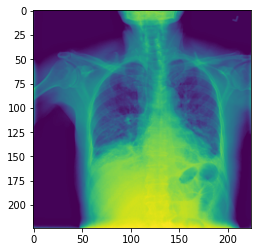

In [7]:
from matplotlib import pyplot
n = 1
print(df['imgs'][n])
print(df['imgs'][n].shape)
pyplot.imshow(df['imgs'][n])

In [8]:
X1 = np.zeros((int(df.shape[0]),224, 224,1))

In [9]:
for i in range(len(X)):
    X1[i] = X[i]

In [10]:
preds = np.zeros((int(df.shape[0]), 16))

In [11]:
for i in range(len(df)):
    for j in range(16):
        preds[i][j] = df[3][i][j]
        #print(type(y[i][j]))
preds[0]

array([ 57.75   ,  33.25   ,  46.59375,  46.59375, 122.9375 ,  33.25   ,
        56.     ,  56.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     ,   0.     ,   0.     ,   0.     ])

In [12]:
preds_class = np.zeros((int(df.shape[0]), 1))

In [13]:
for i in range(len(df)):
    for j in range(16):
        preds_class[i] = df[1][i]
        #print(type(y[i][j]))
preds_class[0]

array([1.])

In [14]:
df = None

In [15]:
preds = tf.constant(preds, shape = (6012,16), dtype = tf.float64)
preds_class = tf.constant(preds_class, shape = (6012,1), dtype = tf.float64)

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Flatten, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError


In [17]:
yolo_model = keras.models.load_model('/content/drive/My Drive/pneumonia yolo/yolo_model11.h5')

In [18]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [19]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = yolo_model (x) 

model = Model(inputs=input_tensor,outputs=out)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
model_1 (Model)              multiple                  62001757  
Total params: 62,001,787
Trainable params: 61,949,179
Non-trainable params: 52,608
_________________________________________________________________


In [21]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 multiple             864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    multiple             128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             multiple             0           bnorm_0[0][0]                    
____________________________________________________________________________________________

Got inputs shapes: [(None, 7, 7, 255), (None, 14, 14, 255), (None, 28, 28, 255)]


In [22]:
x0 = tf.keras.layers.UpSampling2D(size=(2, 2))(model.output[0])
x0 = tf.keras.layers.UpSampling2D(size=(2, 2))(x0)

In [23]:
x1 = tf.keras.layers.UpSampling2D(size=(2, 2))(model.output[1])
x1 = tf.keras.layers.Concatenate(axis=1)([x0, x1])
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(588,  activation = 'relu')(x1)
x1 = Dense(294, activation = 'relu')(x1)
x1 = Dense(147, activation = 'relu')(x1)
regr = Dense(16, activation = 'linear')(x1)
model1 = Model(inputs = model.input, outputs = regr, name = 'regr_op')

[(None, 28, 28, 255), (None, 28, 28, 255), (None, 96)]

In [24]:
import tensorflow

In [25]:
x = GlobalAveragePooling2D()(model.output[2])
x = Dense(48,  activation = 'relu')(x)
x = Dense(24, activation = 'relu')(x)
clf = Dense(1, activation = 'sigmoid', name = 'clf')(x)

In [26]:
modelCLF_REGR = Model(inputs = model1.input, outputs = [regr, clf])

In [27]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [28]:
optimizer = 'adam'
modelCLF_REGR.compile(optimizer = optimizer,
                loss = {'dense_3' : MeanSquaredError(), 'clf' : BinaryCrossentropy()},  
                metrics = {'dense_3' :MeanSquaredError(), 'clf' :BinaryAccuracy()})

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import datetime


checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor = "val_loss", save_best_only = True,
                             save_weights_only = True, mode = "auto")


stop = EarlyStopping(monitor = "val_dense_3_mean_squared_error", patience = 5, mode = "min", 
                     restore_best_weights = True)


reduce_lr = ReduceLROnPlateau(monitor = "val_dense_3_mean_squared_error", factor = 0.2, patience = 2, 
                              min_lr = 1e-6, mode = "auto")

In [30]:
history = modelCLF_REGR.fit(X1, [preds, preds_class],
                      validation_split = 0.2,
                      batch_size = 2,
                      epochs=100, 
                      callbacks=[checkpoint, reduce_lr, stop],
                     )

Epoch 1/100
2405/2405 [==============================] - 190s 79ms/step - loss: 687.3893 - dense_3_loss: 687.3893 - clf_loss: 3.6261e-07 - dense_3_mean_squared_error: 687.4286 - clf_binary_accuracy: 1.0000 - val_loss: 725.4901 - val_dense_3_loss: 725.4901 - val_clf_loss: 8.5099e-15 - val_dense_3_mean_squared_error: 725.2105 - val_clf_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
2405/2405 [==============================] - 185s 77ms/step - loss: 666.1327 - dense_3_loss: 666.1327 - clf_loss: 3.7918e-15 - dense_3_mean_squared_error: 666.0797 - clf_binary_accuracy: 1.0000 - val_loss: 668.9372 - val_dense_3_loss: 668.9372 - val_clf_loss: 4.1143e-15 - val_dense_3_mean_squared_error: 668.6957 - val_clf_binary_accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
2405/2405 [==============================] - 184s 76ms/step - loss: 664.4577 - dense_3_loss: 664.4577 - clf_loss: 1.6436e-14 - dense_3_mean_squared_error: 664.3893 - clf_binary_accuracy: 1.0000 - val_loss: 705.7968 - val_dense_3_loss: 705.796

In [33]:
print(history.history.keys())

dict_keys(['loss', 'dense_3_loss', 'clf_loss', 'dense_3_mean_squared_error', 'clf_binary_accuracy', 'val_loss', 'val_dense_3_loss', 'val_clf_loss', 'val_dense_3_mean_squared_error', 'val_clf_binary_accuracy', 'lr'])


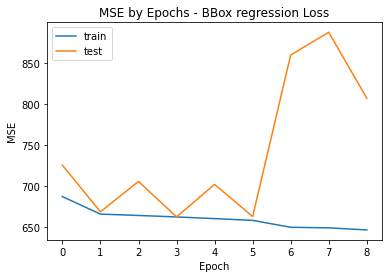

In [34]:
plt.plot(history.history['dense_3_loss'])
plt.plot(history.history['val_dense_3_loss'])
plt.title('MSE by Epochs - BBox regression Loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

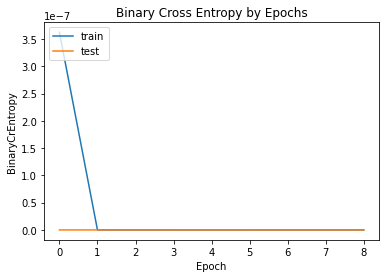

In [36]:
plt.plot(history.history['clf_loss'])
plt.plot(history.history['val_clf_loss'])
plt.title('Binary Cross Entropy by Epochs')
plt.ylabel('BinaryCrEntropy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [31]:
#mascar MCNN

 fine tuning [deep lizard](https://www.youtube.com/watch?v=4Tcqw5oIfIg)
 yolo implemetation [mm](https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/)

<b>References</b>
<a id='yolo_dest'></a>

>**You Only Look Once: Unified, Real-Time Object Detection**
>
>Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi.[[arXiv:1506.02640](https://arxiv.org/abs/1506.02640)]